# CDR EDA
First, import relevant libraries:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

Then, load the data (takes a few moments):

In [2]:
# Load data
df = pd.read_csv("./aws-data/firence_foreigners_3days_past_future.csv", header=None)
df.columns = ['lat', 'lon', 'date_time_m', 'home_region', 'cust_id', 'in_florence']
df.head()

# np.max(data.date_time_m) # max date : '2016-09-30 
# np.min(data.date_time_m) # min date: 2016-06-07 

,lat,lon,date_time_m,home_region,cust_id,in_florence
0,45.628,8.713,2016-06-07 11:24:00,Israel,11,f
1,45.628,8.714,2016-06-07 11:46:00,Israel,11,f
2,45.634,8.703,2016-06-07 11:49:00,Israel,11,f
3,45.623,8.898,2016-06-07 11:59:00,Israel,11,f
4,45.593,8.971,2016-06-07 12:03:00,Israel,11,f


In [ ]:
# Convert the categorical `date_time_m` to a datetime object; then, extract the date component. 
df['datetime'] = pd.to_datetime(df['date_time_m'], format='%Y-%m-%d %H:%M:%S')
df['date'] = df['datetime'].dt.floor('d') # Faster than df['datetime'].dt.date

The code below creates a calls-per-person frequency distribution, which is the first thing we want to see. 

In [3]:
fr = df['cust_id'].value_counts().to_frame()['cust_id'].value_counts().to_frame()
fr.columns = ['frequency']
fr.index.name = 'calls'
fr.reset_index(inplace=True)
fr = fr.sort_values('calls')
fr['cumulative'] = fr['frequency'].cumsum()/fr['frequency'].sum()
fr.head()

,calls,frequency,cumulative
20,1,19344,0.016264
7,2,36466,0.046925
3,3,41900,0.082154
1,4,43555,0.118775
0,5,43636,0.155464


Plot this distribution. This shows that 19344 people made 1 call over the 4 months, 36466 people made 2 calls over the 4 months, 41900 people made 3 calls over the 4 months, etc. 

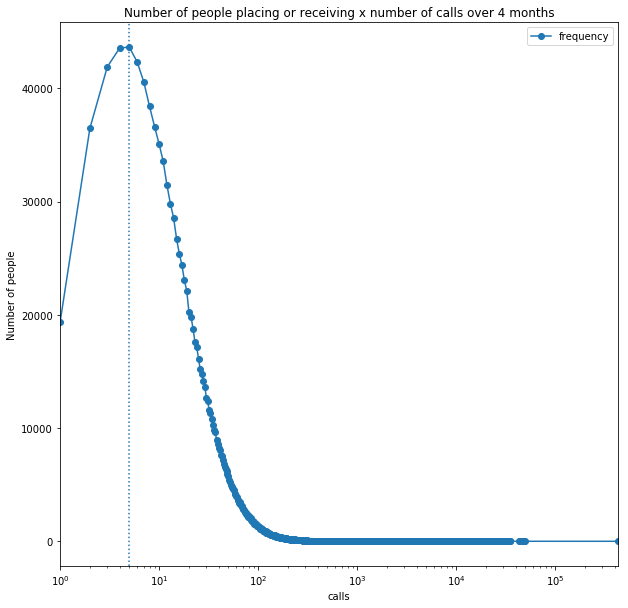

In [4]:
fr.plot(x='calls', y='frequency', style='o-', logx=True, figsize = (10, 10))
plt.axvline(5,ls='dotted')
plt.ylabel('Number of people')
plt.title('Number of people placing or receiving x number of calls over 4 months')

It might be more helpful to look at a cumulative distribution curve, from which we can read off quantiles (e.g., this percentage of the people in the data set had x or more calls, x or fewer calls). Specifically, 10% of people have 3 or fewer calls over the entire period, 25% have 7 of fewer, 33% have 10 or fewer, 50% have 17 of fewer calls, etc., all the way up to 90% of people having 76 or fewer calls. 

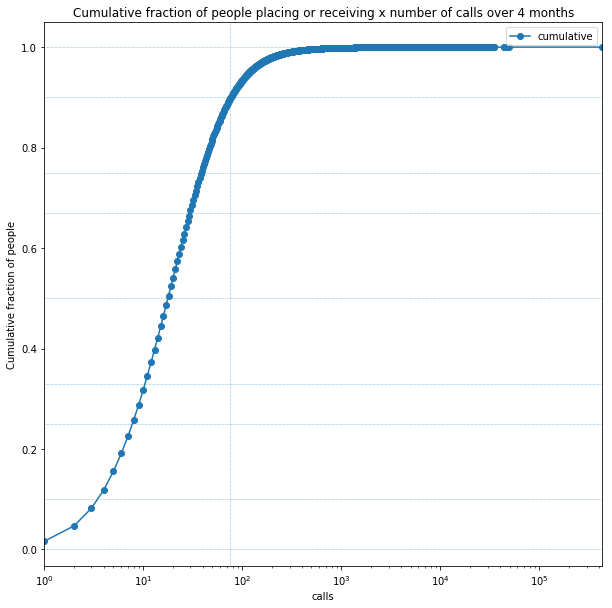

In [5]:
fr.plot(x='calls', y='cumulative', style='o-', logx=True, figsize = (10, 10))
plt.axhline(1.0,ls='dotted',lw=.5)
plt.axhline(.90,ls='dotted',lw=.5)
plt.axhline(.75,ls='dotted',lw=.5)
plt.axhline(.67,ls='dotted',lw=.5)
plt.axhline(.50,ls='dotted',lw=.5)
plt.axhline(.33,ls='dotted',lw=.5)
plt.axhline(.25,ls='dotted',lw=.5)
plt.axhline(.10,ls='dotted',lw=.5)
plt.axhline(0.0,ls='dotted',lw=.5)
plt.axvline(max(fr['calls'][fr['cumulative']<.90]),ls='dotted',lw=.5)
plt.ylabel('Cumulative fraction of people')
plt.title('Cumulative fraction of people placing or receiving x number of calls over 4 months')

We also want to look at the number of unique lat-long addresses, which will (roughly) correspond to either where cell phone towers are, and/or the level of truncation. This takes too long in pandas, so we use postgres, piping the results of the query,
```
\o towers_with_counts.txt
select lat, lon, count(*) as calls, count(distinct cust_id) as users, count(distinct date_trunc('day', date_time_m) ) as days from optourism.cdr_foreigners group by lat, lon order by calls desc;
\q
```
into the file towers_with_counts.txt. This is followed by the bash command
```
cat towers_with_counts.txt | sed s/\ \|\ /'\t'/g | sed s/\ //g | sed 2d > towers_with_counts2.txt
```
to clean up the postgres output format. 

In [13]:
df2 = pd.read_table("./aws-data/towers_with_counts2.txt")
df2.head()

,lat,lon,count
0,43.771,11.254,839141.0
1,43.775,11.252,670489.0
2,43.772,11.264,513066.0
3,43.777,11.248,484600.0
4,43.77,11.247,446210.0


Do the same thing as above. 

In [14]:
fr2 = df2['count'].value_counts().to_frame()
fr2.columns = ['frequency']
fr2.index.name = 'count'
fr2.reset_index(inplace=True)
fr2 = fr2.sort_values('count')
fr2['cumulative'] = fr2['frequency'].cumsum()/fr2['frequency'].sum()
fr2.head()

,count,frequency,cumulative
0,1.0,66,0.003344
15,2.0,54,0.006080
19,3.0,51,0.008663
56,4.0,42,0.010791
36,5.0,46,0.013122


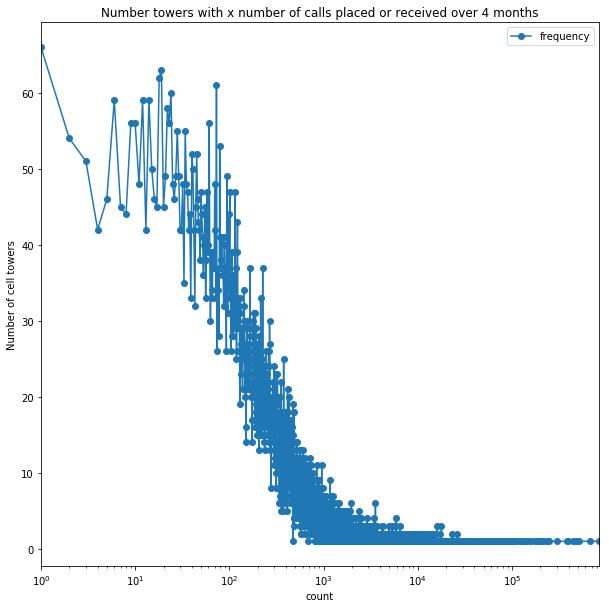

In [18]:
fr2.plot(x='count', y='frequency', style='o-', logx=True, figsize = (10, 10))
# plt.axvline(5,ls='dotted')
plt.ylabel('Number of cell towers')
plt.title('Number of towers with x number of calls placed or received over 4 months')

Unlike the previous plot, this is not very clean at all, making the cumulative distribution plot critical. 

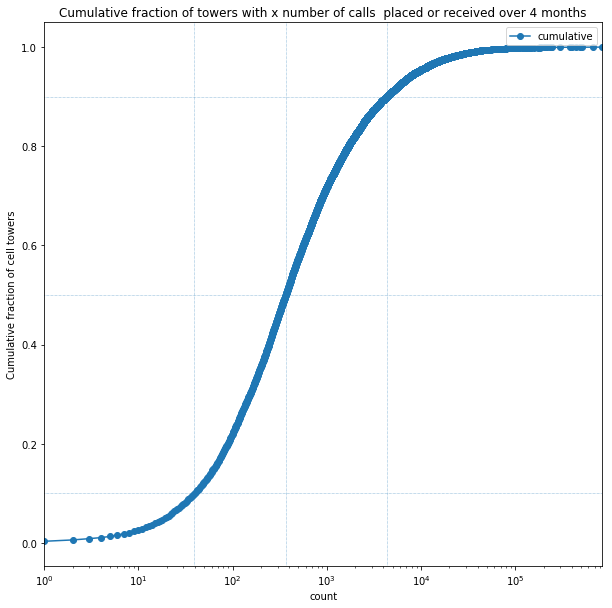

In [21]:
fr2.plot(x='count', y='cumulative', style='o-', logx=True, figsize = (10, 10))
plt.axhline(0.1,ls='dotted',lw=.5)
plt.axvline(max(fr2['count'][fr2['cumulative']<.10]),ls='dotted',lw=.5)
plt.axhline(0.5,ls='dotted',lw=.5)
plt.axvline(max(fr2['count'][fr2['cumulative']<.50]),ls='dotted',lw=.5)
plt.axhline(0.9,ls='dotted',lw=.5)
plt.axvline(max(fr2['count'][fr2['cumulative']<.90]),ls='dotted',lw=.5)
plt.ylabel('Cumulative fraction of cell towers')
plt.title('Cumulative fraction of towers with x number of calls  placed or received over 4 months')

Now, we want to look at temporal data. First, convert the categorical `date_time_m` to a datetime object; then, extract the date component. 

In [6]:
df['datetime'] = pd.to_datetime(df['date_time_m'], format='%Y-%m-%d %H:%M:%S')
df['date'] = df['datetime'].dt.floor('d') # Faster than df['datetime'].dt.date

In [8]:
df2 = df.groupby(['cust_id','date']).size().to_frame()
df2.columns = ['count']
df2.index.name = 'date'
df2.reset_index(inplace=True)
df2.head(20)

,cust_id,date,count
0,11,2016-06-07,19
1,11,2016-06-08,16
2,11,2016-06-09,39
3,11,2016-06-10,2
4,11,2016-06-11,2
5,11,2016-06-12,6
6,11,2016-09-09,5
7,11,2016-09-12,10
8,123,2016-07-28,3
9,123,2016-07-29,33


In [9]:
df3 = (df2.groupby('cust_id')['date'].max() - df2.groupby('cust_id')['date'].min()).to_frame()
df3['calls'] = df2.groupby('cust_id')['count'].sum()
df3.columns = ['days','calls']
df3['days'] = df3['days'].dt.days
df3.head()

,days,calls
cust_id,,
11,97,99
123,5,157
158,98,391
193,6,83
244,35,31


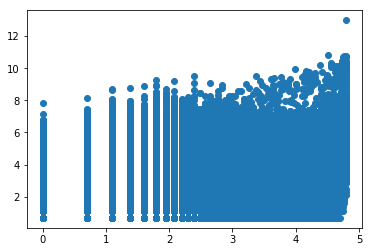

In [17]:
fr = df['cust_id'].value_counts().to_frame()['cust_id'].value_counts().to_frame()

# plt.scatter(np.log(df3['days']), np.log(df3['calls']))
# plt.show()

,cust_id,date,count
0,11,2016-06-07,19
1,11,2016-06-08,16
2,11,2016-06-09,39
3,11,2016-06-10,2
4,11,2016-06-11,2


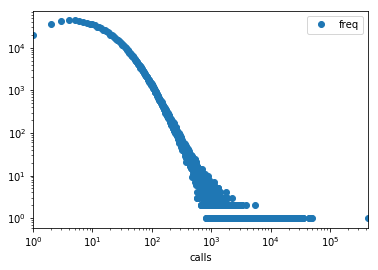

In [77]:
fr.plot(x='calls', y='freq', style='o', logx=True, logy=True)

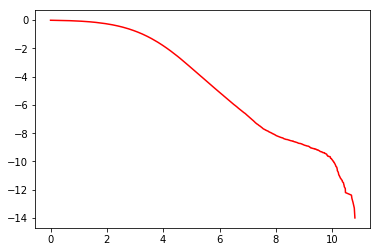

In [97]:
x=np.log(fr['calls'])
y=np.log(1-fr['freq'].cumsum()/fr['freq'].sum())
plt.plot(x, y, 'r-')

In [ ]:
# How many home_Regions
np.count_nonzero(data['home_region'].unique())

In [ ]:
# How many customers
np.count_nonzero(data['cust_id'].unique())

In [ ]:
# How many Nulls are there in the customer ID column?
df['cust_id'].isnull().sum()

In [ ]:
# How many missing data are there in the customer ID?
len(df['cust_id']) - df['cust_id'].count()

In [3]:
df['cust_id'].unique()

array([      11,      123,      158, ..., 30719015, 30719030, 30719039])

In [17]:
data_italians = pd.read_csv("./aws-data/firence_italians_3days_past_future_sample_1K_custs.csv", header=None)
data_italians.columns = ['lat', 'lon', 'date_time_m', 'home_region', 'cust_id', 'in_florence']
regions = np.array(data_italians['home_region'].unique())
regions

array(['home_region', 'Puglia', 'Emilia-Romagna', 'Toscana', 'Lombardia',
       'Campania', 'Umbria', 'Lazio', 'Piemonte', 'Liguria', 'Calabria',
       'Veneto', 'Basilicata', 'Friuli Venezia Giulia', 'Molise',
       'Trentino-Alto Adige', 'Marche', 'Sicilia', 'Abruzzo',
       "Valle D'Aosta", 'Sardegna'], dtype=object)

In [22]:
'Sardegna' in data['home_region']

False